# LSTM for load forecasting

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [27]:
daily = pd.read_csv('../../data/Smart meters in London/ds_master.csv')
daily['day'] = pd.to_datetime(daily['Unnamed: 0'])
daily.set_index('day', inplace=True)
daily.drop(columns='Unnamed: 0', inplace=True)
daily.shape

(831, 14)

Adjust the order of the columns so that they fit in the series to supervised function

In [28]:
daily = daily.loc[daily.index[290:-1], ['energy_sum',
                                         'energy_mean',
                                         'energy_max',
                                         'energy_count',
                                         'energy_std',
                                         'energy_median',
                                         'energy_min',
                                         'temperatureMax',
                                         'temperatureLow',
                                         'windSpeed',
                                         'cloudCover',
                                         'humidity',
                                         'visibility',
                                         'holiday']]
                                     

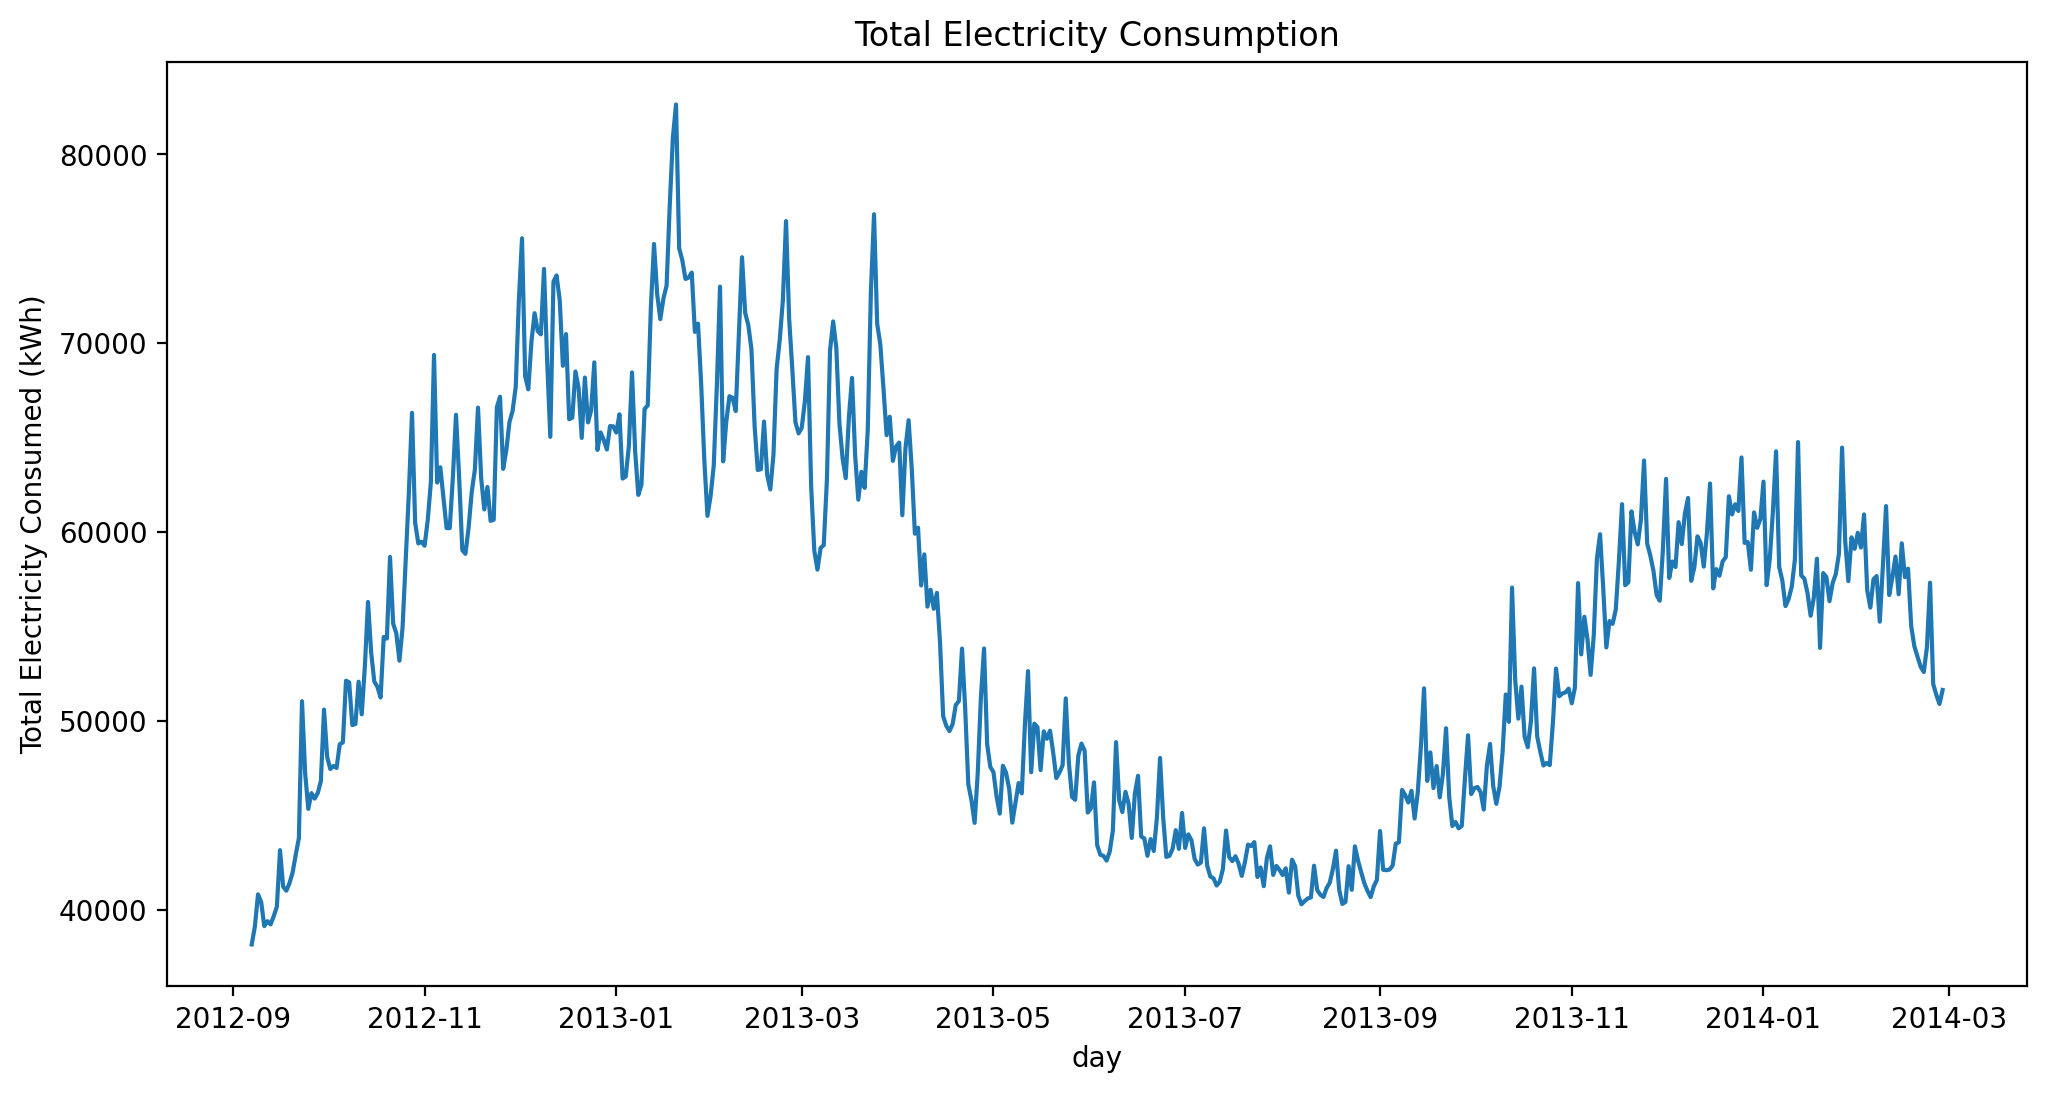

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(daily['energy_sum'])
plt.xlabel('day')
plt.ylabel('Total Electricity Consumed (kWh)')
plt.title('Total Electricity Consumption')
plt.savefig('../../figures/load_figs/Total Electricity Consumption.png')

In [30]:
daily.corr()[['energy_sum', 'energy_mean']].sort_values(by='energy_sum')

,energy_sum,energy_mean
temperatureMax,-0.875222,-0.876493
temperatureLow,-0.785074,-0.787380
visibility,-0.291420,-0.292440
holiday,0.051727,0.050994
windSpeed,0.147877,0.145768
cloudCover,0.302118,0.300059
humidity,0.400611,0.401973
energy_count,0.462204,0.454812
energy_min,0.901384,0.905306
energy_max,0.979661,0.979273


## LSTM Model

In [31]:
daily.head()

,energy_sum,energy_mean,energy_max,energy_count,energy_std,energy_median,energy_min,temperatureMax,temperatureLow,windSpeed,cloudCover,humidity,visibility,holiday
day,,,,,,,,,,,,,,
2012-09-07,38159.509000,795.136704,3283.953000,227989,644.175380,593.7740,249.785,27.12,11.32,1.39,0.14,0.62,12.36,0
2012-09-08,39104.771996,815.038278,3301.584997,227961,642.358898,620.8390,262.225,27.78,16.93,2.97,0.22,0.67,12.20,0
2012-09-09,40813.067001,851.021354,3424.486001,227766,678.194667,636.1965,269.064,20.21,14.77,5.69,0.59,0.78,12.65,0
2012-09-10,40412.297000,841.963338,3392.653998,228078,669.885056,631.8060,264.297,17.82,8.24,4.84,0.37,0.62,13.18,0
2012-09-11,39127.751996,815.402347,3353.844999,228057,659.612747,603.8730,252.426,17.92,8.62,3.93,0.34,0.72,13.16,0


Create function that converts time series data into a shifted series that can be input into a neural network pipeline

citing work from: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [32]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
data = series_to_supervised(daily, 1, 1)
daily.shape, data.shape

((542, 14), (541, 28))

In [48]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

values = daily.values
# ensure all data is float
values = values.astype(float)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
print(values.shape)
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.shape

(542, 14)


(541, 28)

In [35]:
# drop columns that you dont want to predict
reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,0.000000,0.000000,0.000000,0.242014,0.032182,0.000000,0.017327,0.837338,0.655724,0.121926,0.113402,0.345455,0.784993,0.0,0.021248
2,0.021248,0.021452,0.006312,0.241442,0.029633,0.035275,0.078983,0.857671,0.898056,0.283811,0.195876,0.436364,0.773449,0.0,0.059648
3,0.059648,0.060237,0.050311,0.237459,0.079915,0.055292,0.112878,0.624461,0.804752,0.562500,0.577320,0.636364,0.805916,0.0,0.050639
4,0.050639,0.050474,0.038915,0.243832,0.068256,0.049569,0.089252,0.550832,0.522678,0.475410,0.350515,0.345455,0.844156,0.0,0.021765
5,0.021765,0.021844,0.025021,0.243403,0.053843,0.013163,0.030416,0.553913,0.539093,0.382172,0.319588,0.527273,0.842713,0.0,0.027690


### Train test split

In [36]:
daily.shape

(542, 14)

In [42]:
# split into train and test sets
values = reframed.values
n_train_hours = 489
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((489, 1, 14), (489,), (52, 1, 14), (52,))

In [43]:
y_test

array([0.43309788, 0.40282888, 0.41129477, 0.4259545 , 0.45848558,
       0.59809112, 0.43928438, 0.43550396, 0.41843204, 0.39134143,
       0.41238079, 0.45922508, 0.35304949, 0.44211137, 0.43755   ,
       0.40867121, 0.43007124, 0.44090051, 0.46481661, 0.59145177,
       0.48017057, 0.43250045, 0.48462664, 0.47097125, 0.49005426,
       0.4724766 , 0.51193909, 0.4217801 , 0.40103193, 0.43469824,
       0.4385645 , 0.3842489 , 0.4512035 , 0.52188705, 0.41593281,
       0.43681331, 0.46174146, 0.4168732 , 0.47752318, 0.43723539,
       0.4473777 , 0.3790546 , 0.35500645, 0.3426556 , 0.33076693,
       0.32429556, 0.35356157, 0.4306508 , 0.30999162, 0.29700868,
       0.28624297, 0.30292698])

### Set up LSTM

In [40]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)
model.save("load_lstm_model.h5")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM')
plt.legend()

Epoch 1/50
7/7 - 2s - loss: 0.3159 - val_loss: 0.2854 - 2s/epoch - 299ms/step
Epoch 2/50
7/7 - 0s - loss: 0.2218 - val_loss: 0.1655 - 37ms/epoch - 5ms/step
Epoch 3/50
7/7 - 0s - loss: 0.1747 - val_loss: 0.0814 - 40ms/epoch - 6ms/step
Epoch 4/50
7/7 - 0s - loss: 0.1490 - val_loss: 0.0458 - 40ms/epoch - 6ms/step
Epoch 5/50
7/7 - 0s - loss: 0.1314 - val_loss: 0.0452 - 45ms/epoch - 6ms/step
Epoch 6/50
7/7 - 0s - loss: 0.1176 - val_loss: 0.0444 - 50ms/epoch - 7ms/step
Epoch 7/50
7/7 - 0s - loss: 0.1021 - val_loss: 0.0413 - 45ms/epoch - 6ms/step
Epoch 8/50
7/7 - 0s - loss: 0.0876 - val_loss: 0.0417 - 43ms/epoch - 6ms/step
Epoch 9/50
7/7 - 0s - loss: 0.0746 - val_loss: 0.0422 - 41ms/epoch - 6ms/step
Epoch 10/50
7/7 - 0s - loss: 0.0621 - val_loss: 0.0413 - 35ms/epoch - 5ms/step
Epoch 11/50
7/7 - 0s - loss: 0.0509 - val_loss: 0.0409 - 42ms/epoch - 6ms/step
Epoch 12/50
7/7 - 0s - loss: 0.0432 - val_loss: 0.0406 - 38ms/epoch - 5ms/step
Epoch 13/50
7/7 - 0s - loss: 0.0396 - val_loss: 0.0400 - 34ms

KeyboardInterrupt: 

In [45]:
from tensorflow import keras
model = keras.models.load_model("load_lstm_model.h5")

y_pred = model.predict(X_test)
print(y_pred)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
X_test.shape, y_pred.shape, X_train.shape, y_train.shape

2/2 [==============================] - 0s 2ms/step
[[0.4101449 ]
 [0.41014862]
 [0.40164188]
 [0.40065494]
 [0.42547342]
 [0.464999  ]
 [0.57024163]
 [0.44715166]
 [0.44524258]
 [0.42062458]
 [0.3916295 ]
 [0.42666334]
 [0.4466914 ]
 [0.47831166]
 [0.4527397 ]
 [0.4340007 ]
 [0.4158784 ]
 [0.43821368]
 [0.43937036]
 [0.44075355]
 [0.5612393 ]
 [0.47102028]
 [0.43667433]
 [0.5054464 ]
 [0.48342815]
 [0.48334053]
 [0.45121154]
 [0.47970217]
 [0.4263142 ]
 [0.39598486]
 [0.41548255]
 [0.43767723]
 [0.37897536]
 [0.4328045 ]
 [0.48067752]
 [0.42631328]
 [0.4386194 ]
 [0.44946793]
 [0.4076156 ]
 [0.45169982]
 [0.42151657]
 [0.42735723]
 [0.37652475]
 [0.37283763]
 [0.35002992]
 [0.3410595 ]
 [0.32841367]
 [0.33473256]
 [0.39823952]
 [0.2879402 ]
 [0.31120285]
 [0.28756544]]


((52, 14), (52, 1), (489, 14), (489,))

In [50]:
# 反归一化
y_pred = y_pred.reshape((len(y_pred), 1))
xy_pred = pd.concat((pd.DataFrame(X_test[:, 1:]), pd.DataFrame(y_pred)), axis=1)
# xy_pred = np.concatenate((X_test[:,1:], y_pred), axis=1)
print(xy_pred.shape)
xy_pred_inv = scaler.inverse_transform(xy_pred)
y_pred_inv = xy_pred_inv[:,-1]
print(y_pred)
print(y_pred_inv)

y_test = y_test.reshape((len(y_test), 1))
xy_test = np.concatenate((X_test[:,1:], y_test), axis=1)
xy_test_inv = scaler.inverse_transform(xy_test)
y_test_inv = xy_test_inv[:, -1]
print(y_test)
print(y_test_inv)

y_train = y_train.reshape((len(y_train), 1))
xy_train = np.concatenate((X_train[:,1:], y_train), axis=1)
print(xy_train.shape)
xy_train_inv = scaler.inverse_transform(xy_train)
y_train_inv = xy_train_inv[:, -1]

y_pred_inv.shape, y_test_inv.shape, y_train_inv.shape

(52, 14)
[[0.4101449 ]
 [0.41014862]
 [0.40164188]
 [0.40065494]
 [0.42547342]
 [0.464999  ]
 [0.57024163]
 [0.44715166]
 [0.44524258]
 [0.42062458]
 [0.3916295 ]
 [0.42666334]
 [0.4466914 ]
 [0.47831166]
 [0.4527397 ]
 [0.4340007 ]
 [0.4158784 ]
 [0.43821368]
 [0.43937036]
 [0.44075355]
 [0.5612393 ]
 [0.47102028]
 [0.43667433]
 [0.5054464 ]
 [0.48342815]
 [0.48334053]
 [0.45121154]
 [0.47970217]
 [0.4263142 ]
 [0.39598486]
 [0.41548255]
 [0.43767723]
 [0.37897536]
 [0.4328045 ]
 [0.48067752]
 [0.42631328]
 [0.4386194 ]
 [0.44946793]
 [0.4076156 ]
 [0.45169982]
 [0.42151657]
 [0.42735723]
 [0.37652475]
 [0.37283763]
 [0.35002992]
 [0.3410595 ]
 [0.32841367]
 [0.33473256]
 [0.39823952]
 [0.2879402 ]
 [0.31120285]
 [0.28756544]]
[0.4101449  0.41014862 0.40164188 0.40065494 0.42547342 0.46499899
 0.57024163 0.44715166 0.44524258 0.42062458 0.39162949 0.42666334
 0.44669139 0.47831166 0.45273969 0.4340007  0.41587839 0.43821368
 0.43937036 0.44075355 0.5612393  0.47102028 0.43667433 0.505

((52,), (52,), (489,))

In [ ]:
y_test_inv, y_pred_inv

(array([0.43309788, 0.40282888, 0.41129477, 0.4259545 , 0.45848558,
        0.59809112, 0.43928438, 0.43550396, 0.41843204, 0.39134143,
        0.41238079, 0.45922508, 0.35304949, 0.44211137, 0.43755   ,
        0.40867121, 0.43007124, 0.44090051, 0.46481661, 0.59145177,
        0.48017057, 0.43250045, 0.48462664, 0.47097125, 0.49005426,
        0.4724766 , 0.51193909, 0.4217801 , 0.40103193, 0.43469824,
        0.4385645 , 0.3842489 , 0.4512035 , 0.52188705, 0.41593281,
        0.43681331, 0.46174146, 0.4168732 , 0.47752318, 0.43723539,
        0.4473777 , 0.3790546 , 0.35500645, 0.3426556 , 0.33076693,
        0.32429556, 0.35356157, 0.4306508 , 0.30999162, 0.29700868,
        0.28624297, 0.30292698]),
 array([0.4101449 , 0.41014862, 0.40164188, 0.40065494, 0.42547342,
        0.46499899, 0.57024163, 0.44715166, 0.44524258, 0.42062458,
        0.39162949, 0.42666334, 0.44669139, 0.47831166, 0.45273969,
        0.4340007 , 0.41587839, 0.43821368, 0.43937036, 0.44075355,
        0.5612

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt
#回归评价指标
# calculate MSE 均方误差
mse = mean_squared_error(y_test_inv,y_pred_inv)
# calculate RMSE 均方根误差
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(y_test_inv,y_pred_inv)
#calculate R square
r_square=r2_score(y_test_inv,y_pred_inv)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
print('R_square: %.6f' % r_square)

均方误差: 0.002827
均方根误差: 0.053169
平均绝对误差: 0.040820
R_square: 0.307408


In [ ]:
X_train.shape

(489, 14)

In [ ]:
y_train = pd.DataFrame(y_train_inv)
y_test = pd.DataFrame(y_test_inv)
y_pred = pd.DataFrame(y_pred_inv)

In [ ]:
y_true = pd.concat((y_train, y_test), axis=0)
y_true['date'] = daily.index[1::]
y_true['energy_sum'] = y_true[0]
y_true.drop(columns=0, inplace=True)
y_true.set_index('date', inplace=True)

In [ ]:
y_pred['date'] = daily.index[490::]
y_pred['energy_sum'] = y_pred[0]
y_pred.drop(columns=0, inplace=True)
y_pred.set_index('date', inplace=True)

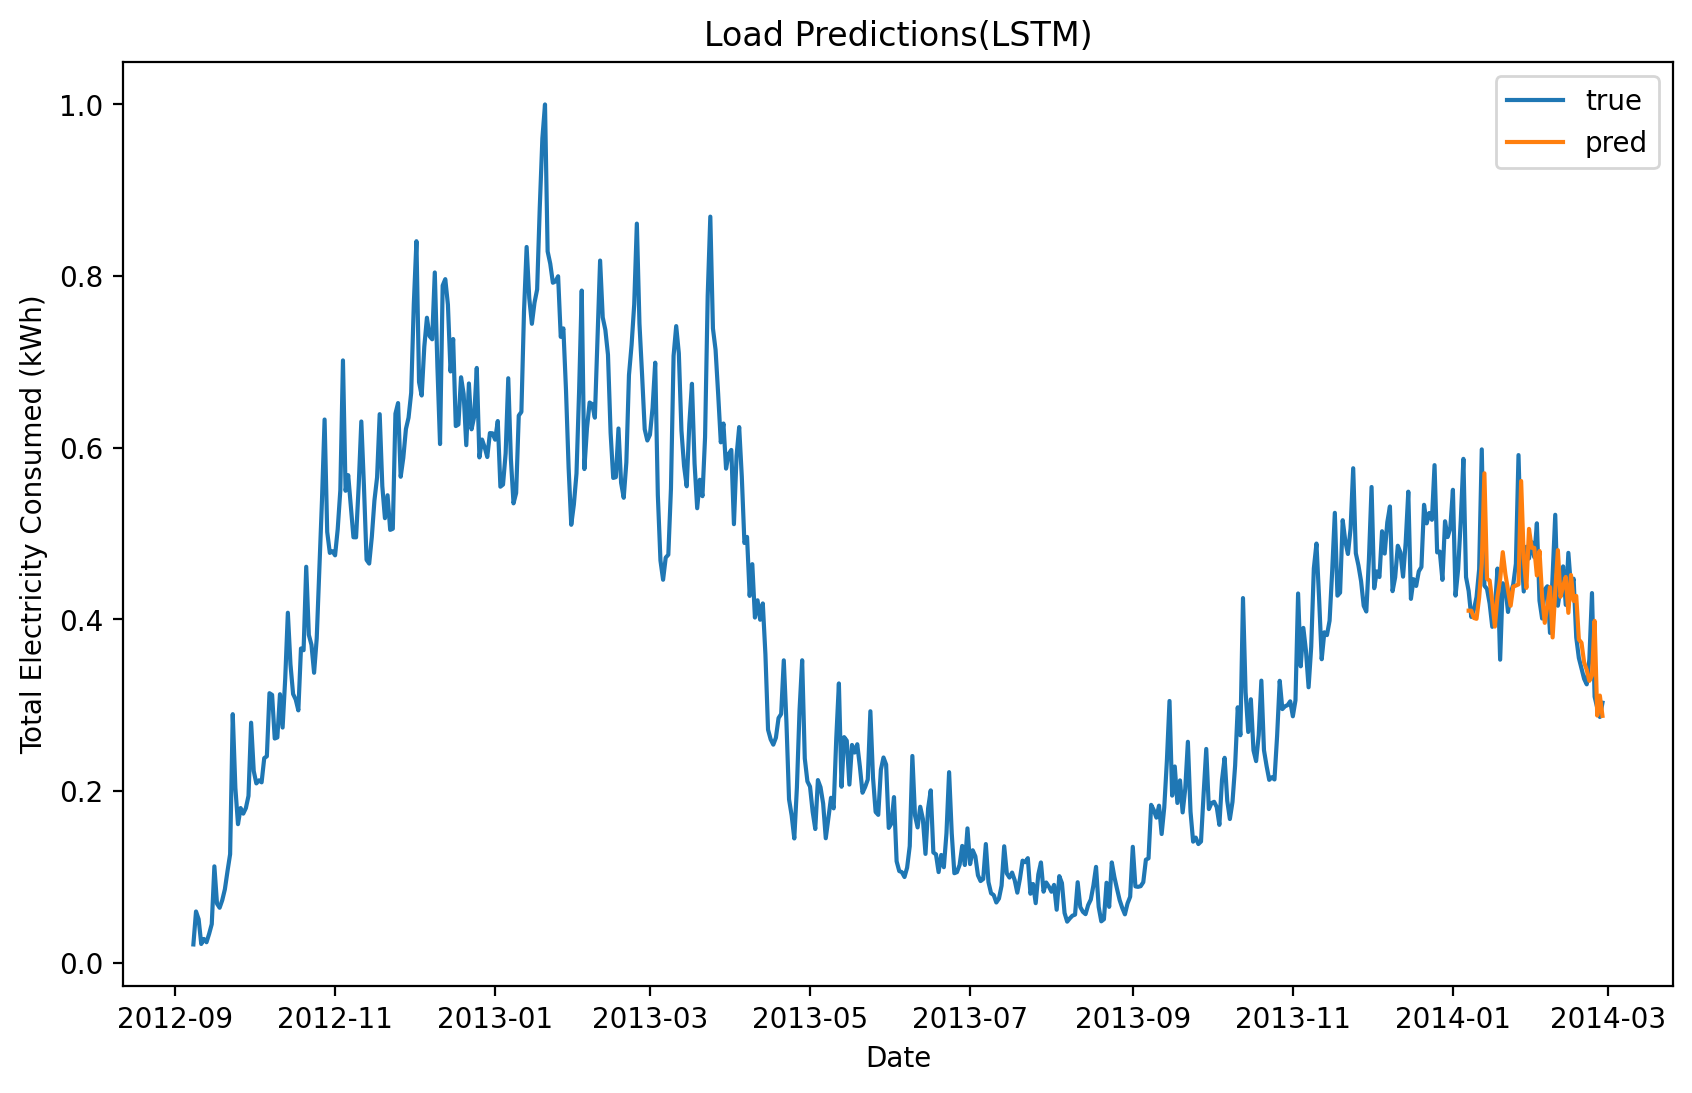

In [ ]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_true.index, y_true['energy_sum'], label='true')
plt.plot(y_pred.index, y_pred['energy_sum'], label='pred')
plt.legend()
plt.title('LSTM NN Energy Sum Predictions')
plt.xlabel('Date')
plt.ylabel('Total Electricity Consumed (kWh)')
plt.title('Load Predictions(LSTM)')
plt.savefig('../../figures/load_figs/Load Predictions(LSTM).png')